In [128]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False

In [129]:
# 데이터 로드
data = pd.read_csv('./data/complete_data.csv')


In [130]:

# 필요한 열 선택
selected_columns = ['계약년월', '거래금액(만원)', '기준금리']
data = data[selected_columns]

In [131]:
data

,계약년월,거래금액(만원),기준금리
0,2013-01-01,21600,2.75
1,2013-01-01,18000,2.75
2,2013-01-01,19000,2.75
3,2013-01-01,18000,2.75
4,2013-01-01,11500,2.75
...,...,...,...
59614,2023-05-01,36000,3.50
59615,2023-05-01,26500,3.50
59616,2023-05-01,31300,3.50
59617,2023-05-01,53000,3.50


In [132]:
# 결측치 처리
data.dropna(inplace=True)  # 결측치가 있는 행 제거

# 시계열 데이터 준비
data['계약년월'] = pd.to_datetime(data['계약년월'])

interest_rate_data = data[['계약년월', '기준금리']].copy()

In [133]:
df = pd.DataFrame(data)


In [134]:
filtered_df = pd.DataFrame(data)


In [135]:
filtered_df['계약년월'] = pd.to_datetime(filtered_df['계약년월'], format='%Y%m')

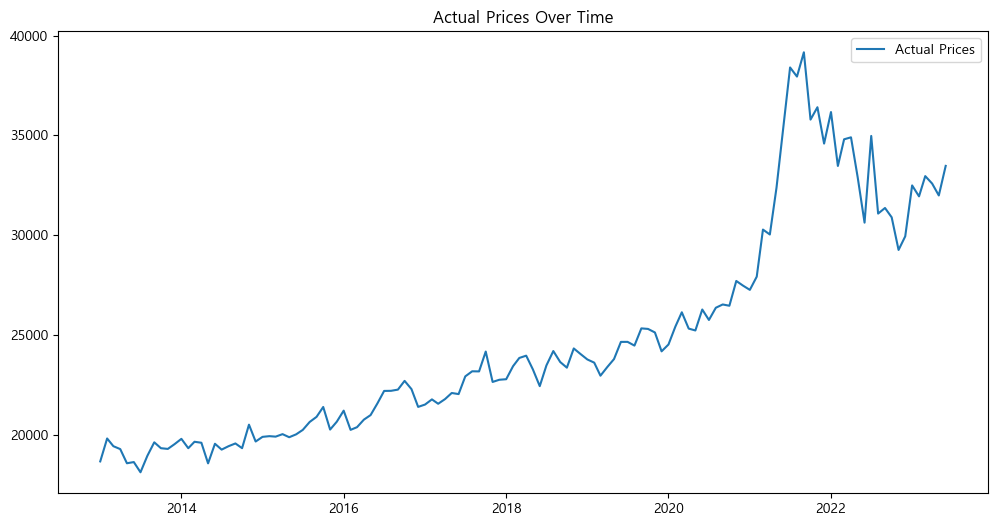

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error

# 중복된 날짜의 거래금액을 평균으로 처리하여 데이터 재구성
data = data.groupby('계약년월')['거래금액(만원)'].mean()


# 시계열 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(data, label='Actual Prices')
plt.title('Actual Prices Over Time')
plt.legend()
plt.show()


In [137]:
data

계약년월
2013-01-01    18654.079602
2013-02-01    19803.343949
2013-03-01    19416.967811
2013-04-01    19270.477137
2013-05-01    18560.891648
                  ...     
2023-02-01    31943.223368
2023-03-01    32958.094937
2023-04-01    32584.983607
2023-05-01    31988.137124
2023-06-01    33471.212121
Name: 거래금액(만원), Length: 125, dtype: float64

In [138]:
filtered_df = pd.DataFrame(data)

In [139]:
filtered_df

,거래금액(만원)
계약년월,
2013-01-01,18654.079602
2013-02-01,19803.343949
2013-03-01,19416.967811
2013-04-01,19270.477137
2013-05-01,18560.891648
...,...
2023-02-01,31943.223368
2023-03-01,32958.094937
2023-04-01,32584.983607


In [140]:
start_date = "2013-01-01"
end_date = "2023-06-01"

filtered_df = filtered_df[(filtered_df.index >= start_date) & (filtered_df.index <= end_date)]

In [141]:
filtered_df

,거래금액(만원)
계약년월,
2013-01-01,18654.079602
2013-02-01,19803.343949
2013-03-01,19416.967811
2013-04-01,19270.477137
2013-05-01,18560.891648
...,...
2023-02-01,31943.223368
2023-03-01,32958.094937
2023-04-01,32584.983607


In [142]:
filtered_df = filtered_df.merge(interest_rate_data, on='계약년월', how='left')

In [143]:
filtered_df=filtered_df.drop_duplicates().reset_index(drop=True)

In [144]:
df = pd.DataFrame(filtered_df)

In [145]:
# 데이터를 시계열로 변환하여 인덱스 설정
df['계약년월'] = pd.to_datetime(df['계약년월'])
df.set_index('계약년월', inplace=True)

In [146]:
df

,거래금액(만원),기준금리
계약년월,,
2013-01-01,18654.079602,2.75
2013-02-01,19803.343949,2.75
2013-03-01,19416.967811,2.75
2013-04-01,19270.477137,2.75
2013-05-01,18560.891648,2.50
...,...,...
2023-02-01,31943.223368,3.50
2023-03-01,32958.094937,3.50
2023-04-01,32584.983607,3.50


In [147]:
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

In [148]:
len(train)

100

In [149]:
len(test)

25

In [150]:
# SARIMA 하이퍼파라미터 설정
p_values = [0, 1, 2]
d_values = [0, 1]
q_values = [0, 1, 2]
s_values = [12]  # 시즌 주기를 변경하여 시도


In [151]:

best_rmse = float('inf')
best_params = None

for p in p_values:
    for d in d_values:
        for q in q_values:
            for s in s_values:
                try:
                    model = SARIMAX(train['거래금액(만원)'], exog=train['기준금리'], order=(p, d, q), seasonal_order=(p, d, q, s))
                    fit_model = model.fit(disp=False)

                    forecast_start = pd.Timestamp('2023-06-01')
                    forecast_end = pd.Timestamp('2025-06-01')
                    forecast_index = pd.date_range(start=forecast_start, end=forecast_end, freq='M')
                    forecast_data_cleaned = train.dropna()
                    forecast_data_cleaned = forecast_data_cleaned[:len(forecast_index)]
                    forecast = fit_model.get_forecast(steps=len(forecast_index), exog=forecast_data_cleaned['기준금리'])
                    forecast_mean = forecast.predicted_mean

                    test_rmse = np.sqrt(mean_squared_error(forecast_data_cleaned['거래금액(만원)'], forecast_mean))
                    if test_rmse < best_rmse:
                        best_rmse = test_rmse
                        best_params = (p, d, q, s)
                except Exception as e:
                    print(f"Error with parameters: ({p}, {d}, {q}, {s}) - {e}")

print(f"Best RMSE: {best_rmse:.2f}")
print(f"Best Parameters: SARIMA{best_params}")


c:\Users\82105\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\82105\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\82105\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\82105\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\82105\AppData\Local\Programs\Python\Python39\lib\si

Best RMSE: 9073.85
Best Parameters: SARIMA(1, 0, 0, 12)


In [152]:
from statsmodels.tsa.stattools import adfuller
import numpy as np

# Dickey-Fuller 검정 함수 정의
def perform_dickey_fuller_test(data):
    result = adfuller(data)
    print("Dickey-Fuller Test Results:")
    print(f'Test Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Lags Used: {result[2]}')
    print(f'Number of Observations Used: {result[3]}')
    print(f'Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

# 시계열 데이터에 Dickey-Fuller 검정 수행
perform_dickey_fuller_test(train['거래금액(만원)'])

# 시계열 데이터 차분 수행
diffed_data = train['거래금액(만원)'].diff().dropna()

# 차분된 데이터에 Dickey-Fuller 검정 수행
perform_dickey_fuller_test(diffed_data)

Dickey-Fuller Test Results:
Test Statistic: 2.805934315490269
p-value: 1.0
Lags Used: 8
Number of Observations Used: 91
Critical Values:
   1%: -3.50434289821397
   5%: -2.8938659630479413
   10%: -2.5840147047458037
Dickey-Fuller Test Results:
Test Statistic: -9.361341315652295
p-value: 7.808088119430517e-16
Lags Used: 1
Number of Observations Used: 97
Critical Values:
   1%: -3.4996365338407074
   5%: -2.8918307730370025
   10%: -2.5829283377617176


In [153]:
best_params = (1, 0, 0, 12)  # 최적의 매개변수로 가정하겠습니다.
# SARIMA 모델 학습
best_order = (1, 1, 1)
best_seasonal_order = (1, 1, 1, 12)
model = SARIMAX(test['거래금액(만원)'], exog=test[['기준금리']], order=best_order, seasonal_order=best_seasonal_order)
fit_model = model.fit(disp=False)

c:\Users\82105\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\82105\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\82105\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


c:\Users\82105\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\82105\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


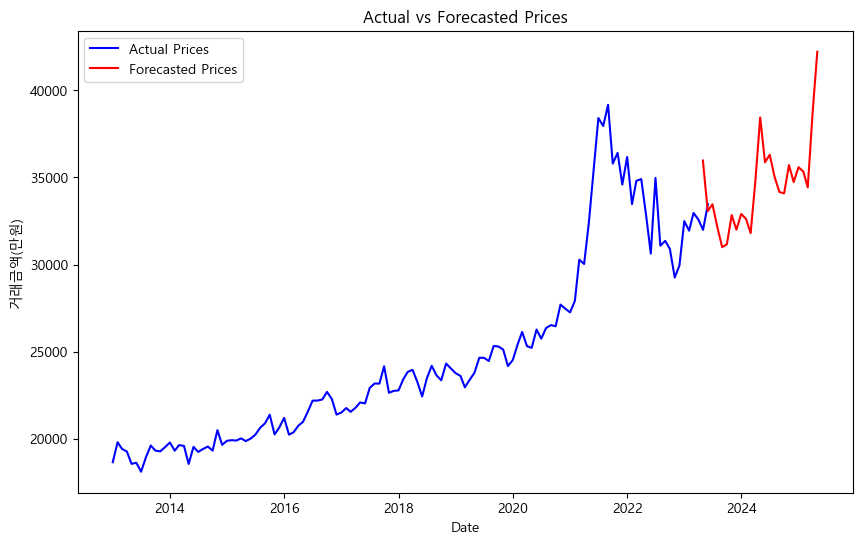

Test RMSE: 4557.11
Test MAE: 4050.15
Test MAPE: 0.12


In [154]:
# 예측 기간 설정 (2022-10-01부터 2023-06-01까지)
forecast_start = pd.Timestamp('2023-04-01')
forecast_end = pd.Timestamp('2025-05-01')
forecast_index = pd.date_range(start=forecast_start, end=forecast_end, freq='M')


# 예측 기간에 맞추어 exog_forecast_data를 생성
exog_forecast_data = train['기준금리'][len(train)-len(forecast_index):].values.reshape(-1, 1)

# 예측 수행
forecast = fit_model.get_forecast(steps=len(forecast_index), exog=exog_forecast_data)
forecast_mean = forecast.predicted_mean


# 그래프 시각화
plt.figure(figsize=(10, 6))

# 학습 데이터와 테스트 데이터의 실제 거래금액 그래프를 연결해서 그림
plt.plot(data, label='Actual Prices', color='blue')

# 예측된 거래금액 그래프를 빨간색으로 그림
plt.plot(forecast_index, forecast_mean, label='Forecasted Prices', color='red')

plt.title('Actual vs Forecasted Prices')
plt.xlabel('Date')
plt.ylabel('거래금액(만원)')
plt.legend()

plt.show()

test_rmse = np.sqrt(mean_squared_error(test['거래금액(만원)'], forecast_mean))
test_mae = mean_absolute_error(test['거래금액(만원)'], forecast_mean)
test_mape = mean_absolute_percentage_error(test['거래금액(만원)'], forecast_mean)

print(f'Test RMSE: {test_rmse:.2f}')
print(f'Test MAE: {test_mae:.2f}')
print(f'Test MAPE: {test_mape:.2f}')
